In [267]:
import pandas as pd
import matplotlib.pyplot as plt

# Competitiveness against fossil fuels

In [268]:
# state-level natural gas prices
state_ng = pd.read_excel('./input_data/ng_prices_state_annual_us.xlsx', sheet_name='clean_data_2022', header=0 ).transpose()
state_ng.reset_index(inplace=True)
state_ng.rename(columns={0:'NG price ($/MMBtu)', 'index':'state'}, inplace=True)
state_ng['state'] = state_ng.apply(lambda x:x['state'].split(' Natural')[0], axis=1)
state_ng.set_index('state', inplace=True)

In [269]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_states = pd.DataFrame(us_state_to_abbrev.items(), columns=['state', 'abbrev'])

abbrev_states.set_index('state', inplace=True)
state_ng = state_ng.merge(abbrev_states, on='state')
state_ng.reset_index(inplace=True)
state_ng.head(2)

,state,NG price ($/MMBtu),abbrev
0,Alabama,7.87,AL
1,Alaska,6.72,AK


In [270]:
excel_results =  './results/clean_results_anr_lr_0_h2_lr_0_wacc_0.077.xlsx'
ammonia = pd.read_excel(excel_results, sheet_name='ammonia')
heat = pd.read_excel(excel_results, sheet_name='process_heat')
refining = pd.read_excel(excel_results, sheet_name='refining')
steel = pd.read_excel(excel_results, sheet_name='steel')
#ammonia = ammonia[['state', 'Breakeven price ($/MMBtu)','Viable avoided emissions (MMT-CO2/year)', 'ANR']]
ammonia['Industry'] = 'Ammonia'
#heat = heat[['state', 'Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)','ANR']]
heat['Industry'] = 'Process heat'
#steel = steel[['state', 'Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)','ANR']]
steel['Industry'] = 'Steel'



In [271]:
#refining = refining[['state', 'Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)','ANR']]
abbrev_states.reset_index(inplace=True)
abbrev_states['state'] = abbrev_states.apply(lambda x:x['state'].upper(), axis=1)
refining = refining.merge(abbrev_states,left_on='state', right_on='state')
refining['Industry'] = 'Refining'
refining.drop(columns=['state'], inplace=True)
refining.rename(columns={'abbrev':'state'}, inplace=True)


In [272]:
total = pd.concat([ammonia, heat, refining, steel], ignore_index=True)
total.columns

Index(['id', 'state', 'Ammonia capacity (tNH3/year)', 'H2 Dem. (kg/day)',
       'Aux Elec Dem. (MWe)', 'Net Revenues ($/year)', 'PEM', 'Alkaline',
       'HTSE', 'Ann. CO2 emissions (kgCO2eq/year)', 'ANR CAPEX ($/year)',
       'H2 CAPEX ($/year)', 'ANR O&M ($/year)', 'H2 O&M ($/year)', 'ANR CRF',
       'Depl. ANR Cap. (MWe)', 'ANR type', '# ANR modules',
       'Breakeven price ($/MMBtu)', 'Power in MWt', 'Reactor',
       'Deployed Power (MWt)', 'ANR Nameplate Capacity (GWt)',
       'Cum h2 dem (t/day)', 'Viable ANR modules count',
       'Viable ANR ammonia plants count', 'Plant', 'City', 'State',
       'Capacity (tNH3/year)', 'H2 Dem. (kg/year)', 'Electricity demand (MWe)',
       'NG path GHG (tCO2/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)',
       'Viable avoided emissions (MMT-CO2/year)', 'Industry',
       'Heat Dem. (MJ/year)', 'Cum dem (t/day)', 'Viable ANR plants count',
       'C intensity (tCO2/MMBtu)', 'FACILITY_ID', 'MMTCO2E',
       'Viable ANR refineries c

In [273]:
total_with_ng = total.merge(state_ng, left_on='state', right_on='abbrev')
total_with_ng.rename(columns={'NG price ($/MMBtu)':'State-level price ($/MMBtu)'}, inplace=True)
print(total_with_ng.sort_values(by='State-level price ($/MMBtu)').tail(20))

          id state_x  Ammonia capacity (tNH3/year)  H2 Dem. (kg/day)  \
339  1002618      NJ                           NaN       1832.882377   
338  1006708      NJ                           NaN       8457.246886   
350  1006673      DE                           NaN       2905.873193   
351   DE_DEL      DE                           NaN      66652.448928   
349  1005303      DE                           NaN      15778.683849   
332  1000553      MD                           NaN      56501.304084   
247   PH_ROD      CA                           NaN      14586.816152   
248   SA_BAK      CA                           NaN       2652.148391   
237    Ch_El      CA                       25000.0      34569.339347   
238  1005800      CA                           NaN      10666.318594   
239  1002601      CA                           NaN       9905.983697   
240  1007805      CA                           NaN       4329.369747   
241   VA_BEN      CA                           NaN      89510.00

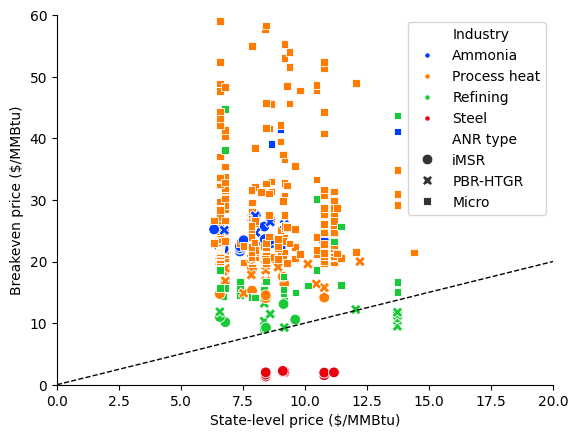

In [274]:
# plot
import seaborn as sns
import numpy as np
ax = sns.scatterplot(data=total_with_ng, x='State-level price ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)', hue='Industry', palette='bright', style='ANR type', marker='.', s=60)
ax.set_ylim(0,60)
ax.set_xlim(0,20)
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, color='k', linestyle='--', linewidth=1, label='No CO2 tax')
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('./results/be_ng_state.png')

# Economic impact of incentives

In [275]:
carbon_prices = [230, 270, 310] #$/tCO2 for 2030, 2040, 2050 from EPA social cost of carbon
h2_ptc = 3 #$/kgH2 clean
elec_ptc = 25 #$/MWhe
avg_elec_cons_h2 = 0.022 #MWhe/kgh2, calculated from avg thermal efficiency (micro, PBR-HTGR, iMSR) and coupling efficiency with HTSE

# NH3
nh3_carbon_intensity = 2.30 # tcO2/tNH3
nh3_nrj_intensity = 30.82 #MMBtu/tNH3
nh3_h2_intensity = 507.71 # kgh2/tNH3
nh3_carbon_prices = [c*nh3_carbon_intensity/nh3_nrj_intensity for c in carbon_prices]
nh3_h2_ptc = h2_ptc*nh3_h2_intensity/nh3_nrj_intensity
nh3_elec_ptc = elec_ptc*avg_elec_cons_h2*nh3_h2_intensity/nh3_nrj_intensity

# Refining
smr_carbon_intensity = 11.888 #kgCO2/kgh2
smr_nrj_intensity = 0.1578 # MMBtu/kgh2
refining_carbon_prices = [c*smr_carbon_intensity/(1e3*smr_nrj_intensity) for c in carbon_prices]
refining_h2_ptc = h2_ptc/smr_nrj_intensity
refining_elec_ptc = elec_ptc*avg_elec_cons_h2/smr_nrj_intensity

# Process heat
heat_avg_carbon_intensity = 0.002028 #tCO2/MMBtu
h2_hhv = 141.88 # MJ/kgh2
mmbtu_to_mj = 1055.06 #mj/MmBtu
heat_carbon_prices = [c*heat_avg_carbon_intensity for c in carbon_prices]
heat_h2_ptc = h2_ptc*mmbtu_to_mj/h2_hhv
heat_elec_ptc = elec_ptc*avg_elec_cons_h2*mmbtu_to_mj/h2_hhv

# Steel
coal_to_steel_ratio_bau = 0.474 # tcoal/tsteel
co2_to_steel_ratio_bau = 1.990 #tco2/tsteel
h2_to_dri_ratio = 67.095 #kgh2/tdri
steel_to_dri_ratio = 0.9311 # tsteel/tdri
aux_elec_dri = 0.1025 # MWhe/tdri
eaf_elec = 0.461 # MWhe/tsteel
steel_carbon_prices = [c*co2_to_steel_ratio_bau/coal_to_steel_ratio_bau for c in carbon_prices]
steel_h2_ptc = h2_ptc*h2_to_dri_ratio/(steel_to_dri_ratio*coal_to_steel_ratio_bau) 


## Ammonia

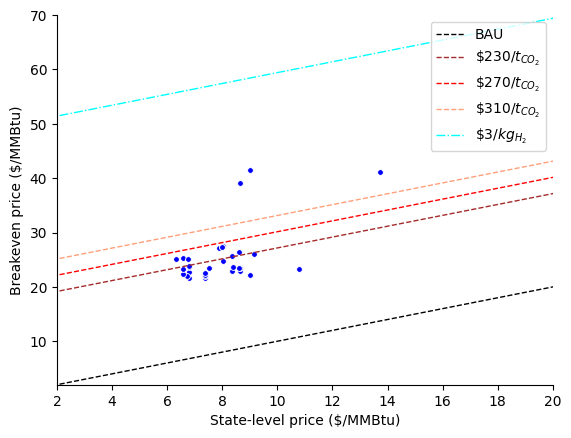

In [276]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Ammonia'], x='State-level price ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)',color='b', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+nh3_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+nh3_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+nh3_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+nh3_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+nh3_elec_ptc for x in med_x]
#ax.plot(med_x, elec, color='magenta', linestyle='dotted', linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/ammonia_be_state_with_carbon_prices.png')

## Process heat

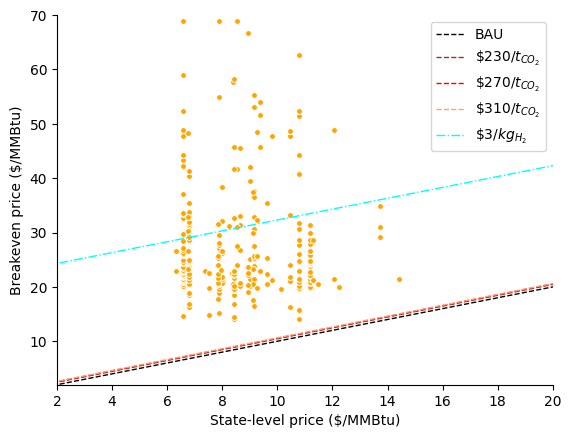

In [277]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Process heat'], x='State-level price ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)',color='orange', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+heat_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+heat_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+heat_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+heat_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+heat_elec_ptc for x in med_x]
#ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')



ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/process_heat_be_state_with_carbon_prices.png')

## Refining

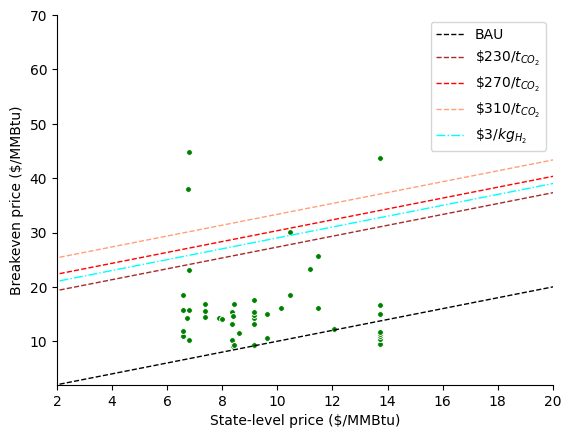

In [278]:
# Plot
ax = sns.scatterplot(data=total_with_ng[total_with_ng['Industry']=='Refining'], x='State-level price ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)',color='g', marker='.', s=70)
ax.set_ylim(2,70)
ax.set_xlim(2,20)

# BAU
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+refining_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+refining_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+refining_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+refining_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
elec = [x+refining_elec_ptc for x in med_x]
#ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0)
plt.savefig('./results/refining_be_state_with_carbon_prices.png')

## Steel

In [279]:

division_coal = pd.read_excel('./input_data/coal_prices_2023_division_us.xlsx', sheet_name='coal_prices')
state_to_division_map = pd.read_excel('./input_data/coal_prices_2023_division_us.xlsx', sheet_name='state_to_division_map')
state_coal = state_to_division_map.merge(division_coal, on='division')
steel_with_state_prices = steel.merge(state_coal, on='state')
steel_with_state_prices['Industry'] = 'Steel'
import utils
steel_with_state_prices['price 2023 ($/MMBtu)'] = steel_with_state_prices['price 2023 ($/tcoal)']/utils.coal_heat_content

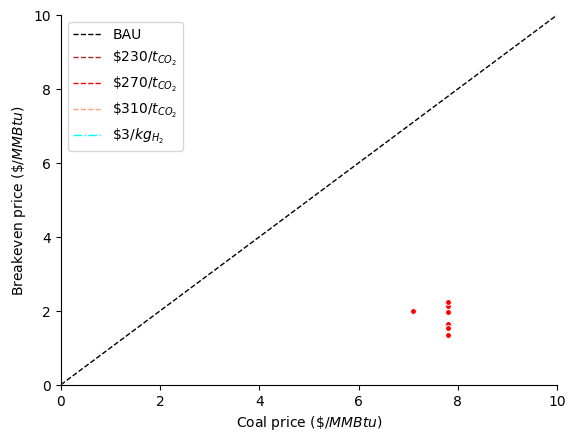

In [280]:
# Plot
ax = sns.scatterplot(data=steel_with_state_prices, x='price 2023 ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)',color='r', marker='.', s=70)
ax.set_ylim(0,10)
ax.set_xlim(0,10)
ax.set_xlabel(r'Coal price ($\$/MMBtu$)')
ax.set_ylabel(r'Breakeven price ($\$/MMBtu$)')

# BAU
med_x = np.arange(0,500,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
#  EPA social cost of carbon pricing
c2030 = [x+steel_carbon_prices[0] for x in med_x]
ax.plot(med_x, c2030, color='brown', linestyle='--', linewidth=1, label=r'\$230/$t_{CO_2}$')
c2040= [x+steel_carbon_prices[1] for x in med_x]
ax.plot(med_x, c2040, color='r', linestyle='--', linewidth=1, label=r'\$270/$t_{CO_2}$')
c2050= [x+steel_carbon_prices[2] for x in med_x]
ax.plot(med_x, c2050, color='lightsalmon', linestyle='--', linewidth=1, label=r'\$310/$t_{CO_2}$')
h2 = [x+steel_h2_ptc for x in med_x]
ax.plot(med_x, h2, color='cyan', linestyle='-.', linewidth =1, label=r'\$3/$kg_{H_2}$')
#elec = [x+steel_elec_ptc for x in med_x]
#ax.plot(med_x, elec, color='magenta', linestyle='dotted',linewidth =1, label=r'\$25/$MWh_e$')

ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc='upper left')
plt.savefig('./results/steel_be_state_with_carbon_prices.png')

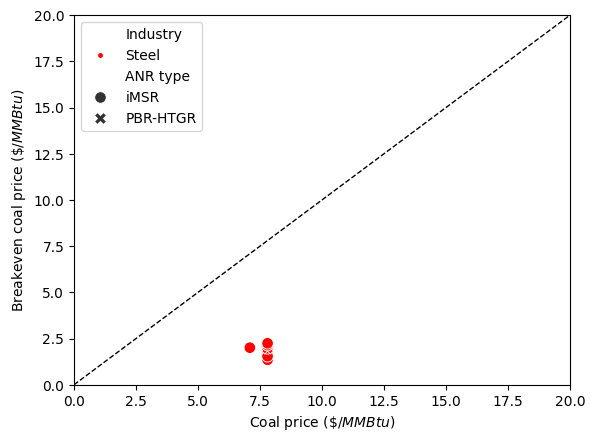

In [281]:
# Plot
ax = sns.scatterplot(data=steel_with_state_prices, x='price 2023 ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)',palette=['r'], marker='.', style='ANR type',s=70, hue='Industry')
ax.set_ylim(0,20)
ax.set_xlim(0,20)
ax.set_xlabel(r'Coal price ($\$/MMBtu$)')
ax.set_ylabel(r'Breakeven coal price ($\$/MMBtu$)')

# BAU
med_x = np.arange(0,500,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=1, label='BAU')
plt.savefig('./results/be_coal_state.png')

# Comparison against revenues from electricity sales

In [282]:
electricity_prices_hub = pd.read_excel('./input_data/electricity_prices_hubs_2023.xlsx', sheet_name='data')
state_hub_map = pd.read_excel('./input_data/electricity_prices_hubs_2023.xlsx', sheet_name='state_to_hub')
electricity_prices = state_hub_map.merge(electricity_prices_hub, on='hub')
#electricity_prices = electricity_prices[['state', 'average price ($/MWhe)']]
electricity_prices.head(3)

,state,hub,average price ($/MWhe)
0,WA,Northwest,78
1,OR,Northwest,78
2,MT,Northwest,78


In [283]:
ammonia = ammonia.merge(electricity_prices, on='state')
ammonia['Elec sales (bn$/year)'] = ammonia['Depl. ANR Cap. (MWe)']*ammonia['average price ($/MWhe)']*24*365/1e9 #$/year
ammonia['Avoided fossil fuel cost (bn$/year)'] = nh3_nrj_intensity*ammonia['Ammonia capacity (tNH3/year)']*ammonia['Breakeven price ($/MMBtu)']/1e9
ammonia.head(3)

,id,state,Ammonia capacity (tNH3/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),PEM,Alkaline,HTSE,Ann. CO2 emissions (kgCO2eq/year),...,H2 Dem. (kg/year),Electricity demand (MWe),NG path GHG (tCO2/year),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year),Industry,hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,CF_Do,LA,3935000,5.441214e+06,2.227288,-2.624499e+09,0,0,5442,5.103946e+08,...,1.986043e+09,53.454909,9050500.0,8.540105,8.540105,Ammonia,MISO,34,1.469840,2.617298
1,Nu_Ge,LA,535000,7.397839e+05,0.302821,-3.754586e+08,0,0,740,6.940317e+07,...,2.700211e+08,7.267694,1230500.0,1.161097,19.065694,Ammonia,MISO,34,0.209977,0.374480
2,Mo_Fa,LA,510000,7.052145e+05,0.288670,-3.724385e+08,0,0,706,6.621437e+07,...,2.574033e+08,6.928082,1173000.0,1.106786,31.407648,Ammonia,MISO,34,0.209977,0.371505


In [284]:
heat = heat.merge(electricity_prices, on='state')
heat['Elec sales (bn$/year)'] = heat['Depl. ANR Cap. (MWe)']*heat['average price ($/MWhe)']*24*365/1e9 #$/year
heat['Avoided fossil fuel cost (bn$/year)'] = heat['Heat Dem. (MJ/year)']*heat['Breakeven price ($/MMBtu)']/(mmbtu_to_mj*1e9)
heat.head(3)

,id,state,H2 Dem. (kg/day),Heat Dem. (MJ/year),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),...,C intensity (tCO2/MMBtu),FACILITY_ID,MMTCO2E,Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year),Industry,hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,1000588,IN,153100.342414,7.928485e+09,-1.055331e+08,0,154.0,0,1.444336e+07,3.485662e+07,...,0.001922,1000588,0.399145,0.384701,0.384701,Process heat,MISO,34,0.041995,0.105533
1,1000418,IN,433411.991729,2.244476e+10,-3.089026e+08,0,434.0,0,4.070402e+07,1.045699e+08,...,0.001913,1000418,1.129939,1.089235,1.853337,Process heat,MISO,34,0.125986,0.308901
2,1003962,IN,217798.459719,1.127895e+10,-1.800861e+08,0,218.0,0,1.970790e+07,6.626269e+07,...,0.001844,1003962,0.567818,0.548110,5.821754,Process heat,MISO,34,0.071482,0.180085


In [285]:

refining = refining.merge(electricity_prices, on='state')
refining['Elec sales (bn$/year)'] = refining['Depl. ANR Cap. (MWe)']*refining['average price ($/MWhe)']*24*365/1e9 #$/year
refining['Avoided fossil fuel cost (bn$/year)'] = refining['H2 Dem. (kg/day)']*365*smr_nrj_intensity*refining['Breakeven price ($/MMBtu)']/1e9
refining.head(3)

,id,H2 Dem. (kg/day),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),ANR CAPEX ($/year),H2 CAPEX ($/year),ANR O&M ($/year),...,Viable ANR modules count,Viable ANR refineries count,Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year),state,Industry,hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,CH_PAS,296403.233462,-1.484734e+08,0,297.0,0,2.785506e+07,6.971323e+07,1.194230e+07,52378680,...,2,1,1.258274,1.258274,MS,Refining,SERC,32,0.079050,0.154881
1,ER_VIC,16826.384432,-1.357679e+07,0,17.0,0,1.279163e+06,8.827701e+06,5.484157e+05,3537600,...,47,23,0.071733,10.957726,MS,Refining,SERC,32,0.003756,0.014163
2,Fl_SAI,288453.321893,-1.477628e+08,0,289.0,0,2.710475e+07,6.971323e+07,1.162062e+07,52378680,...,4,2,1.224529,2.482803,MN,Refining,MISO,34,0.083991,0.154140


In [286]:
steel = steel.merge(electricity_prices, on='state')
steel['Elec sales (bn$/year)'] = steel['Depl. ANR Cap. (MWe)']*steel['average price ($/MWhe)']*24*365/1e9
steel['Avoided fossil fuel cost (bn$/year)'] = steel['Steel prod. (ton/year)']*coal_to_steel_ratio_bau*steel['Breakeven price ($/MMBtu)']/1e9
steel.head(3)

,id,state,Steel prod. (ton/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),...,Steel production capacity (ttpa),Hydrogen demand (kg/day),Electricity demand (MWe),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year),Industry,hub,average price ($/MWhe),Elec sales (bn$/year),Avoided fossil fuel cost (bn$/year)
0,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236000,1.033714e+06,341.347061,-1.710215e+09,0,1034,0,3.064169e+08,...,5236,1.033714e+06,341.347061,5.128152,5.128152,Steel,MISO,34,0.377959,0.003348
1,U.S. Steel Gary Works,IN,6622000,1.307345e+06,431.703636,-2.200650e+09,0,1308,0,3.875548e+08,...,6622,1.307345e+06,431.703636,9.913172,17.819341,Steel,MISO,34,0.503945,0.005165
2,Cleveland-Cliffs Burns Harbor steel plant,IN,3635000,7.176379e+05,236.974134,-1.233202e+09,0,718,0,2.127398e+08,...,3635,7.176379e+05,236.974134,6.626498,30.501912,Steel,MISO,34,0.293968,0.003457


In [287]:
ammonia['Industry'] = 'Ammonia'
refining['Industry'] = 'Refining'
heat['Industry'] = 'Process heat'
steel['Industry'] = 'Steel'


total_elec = pd.concat([ammonia, refining, heat, steel], ignore_index=True)
elec_to_print = total_elec[['state', 'average price ($/MWhe)', 'Elec sales (bn$/year)', 'Avoided fossil fuel cost (bn$/year)', 'Industry']]
elec_to_print.to_excel('./results/comparison_electricity_hydrogen.xlsx', index=False)
total_elec.rename(columns={'average price ($/MWhe)':'Avg price ($/MWhe)'}, inplace=True)
total_elec.columns


Index(['id', 'state', 'Ammonia capacity (tNH3/year)', 'H2 Dem. (kg/day)',
       'Aux Elec Dem. (MWe)', 'Net Revenues ($/year)', 'PEM', 'Alkaline',
       'HTSE', 'Ann. CO2 emissions (kgCO2eq/year)', 'ANR CAPEX ($/year)',
       'H2 CAPEX ($/year)', 'ANR O&M ($/year)', 'H2 O&M ($/year)', 'ANR CRF',
       'Depl. ANR Cap. (MWe)', 'ANR type', '# ANR modules',
       'Breakeven price ($/MMBtu)', 'Power in MWt', 'Reactor',
       'Deployed Power (MWt)', 'ANR Nameplate Capacity (GWt)',
       'Cum h2 dem (t/day)', 'Viable ANR modules count',
       'Viable ANR ammonia plants count', 'Plant', 'City', 'State',
       'Capacity (tNH3/year)', 'H2 Dem. (kg/year)', 'Electricity demand (MWe)',
       'NG path GHG (tCO2/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)',
       'Viable avoided emissions (MMT-CO2/year)', 'Industry', 'hub',
       'Avg price ($/MWhe)', 'Elec sales (bn$/year)',
       'Avoided fossil fuel cost (bn$/year)', 'Viable ANR refineries count',
       'Heat Dem. (MJ/year)', 

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_18280\2528035591.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


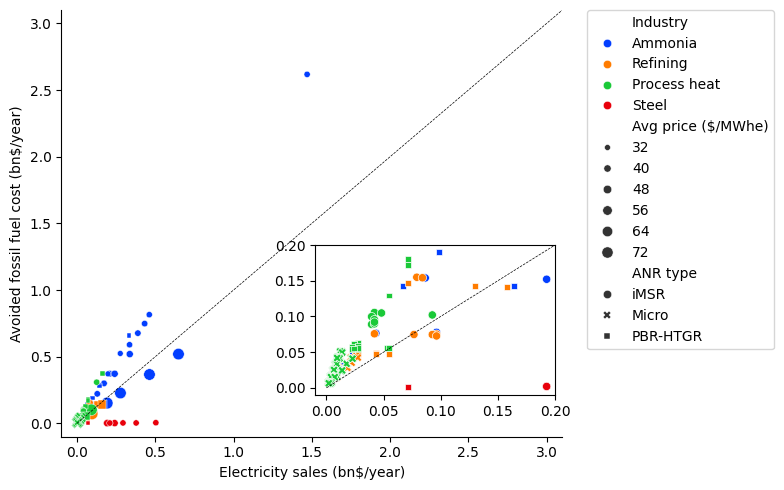

In [288]:
total_elec.rename(columns={'average price':'Avg price ($/MWhe)'}, inplace=True)
ax = sns.scatterplot(data=total_elec, x='Elec sales (bn$/year)', y='Avoided fossil fuel cost (bn$/year)', size='Avg price ($/MWhe)',palette='bright', hue='Industry', style='ANR type')
med_x = np.arange(0,4,0.05)
ax.plot(med_x, med_x, 'k--', linewidth=0.5)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
ax.set_xlim(-.1,3.1)
ax.set_ylim(-.1,3.1)
ax.set_xlabel('Electricity sales (bn$/year)')
#plt.savefig('./results/steel_be_state_with_carbon_prices.png')

# this is an inset axes over the main axes
sub_ax = plt.axes([.4, .2, .3, .3]) 
sns.scatterplot(ax = sub_ax, data=total_elec, x='Elec sales (bn$/year)', y='Avoided fossil fuel cost (bn$/year)', palette='bright', style='ANR type', hue='Industry')
sub_ax.plot(med_x, med_x, 'k--', linewidth=0.5)
sub_ax.set_xlim(-.01, 0.2)
sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
fig = ax.get_figure()
fig.set_size_inches((8,5))
fig.tight_layout()
plt.savefig('./results/avoided_fossil_vs_elec_sales.png')

# Viable decarbonization

In [289]:
gvt_incentives = [r'\$230/$t_{CO_2}$', r'\$270/$t_{CO_2}$', r'\$310/$t_{CO_2}$', r'\$3/$kg_{H_2}$']
viable_decarb_df = pd.DataFrame(columns=['CO2 2030', 'CO2 2040', 'CO2 2050', 'H2 PTC'], index=['Ammonia', 'Refining', 'Process heat', 'Steel'])
viable_decarb_df

,CO2 2030,CO2 2040,CO2 2050,H2 PTC
Ammonia,NaN,NaN,NaN,NaN
Refining,NaN,NaN,NaN,NaN
Process heat,NaN,NaN,NaN,NaN
Steel,NaN,NaN,NaN,NaN


In [290]:
ammonia = ammonia.merge(state_ng, left_on='state', right_on='abbrev')
heat = heat.merge(state_ng, left_on='state', right_on='abbrev')
refining = refining.merge(state_ng, left_on='state', right_on='abbrev')


In [291]:
# ammonia
ammonia_c_2030 = ammonia[ammonia['Breakeven price ($/MMBtu)']<=nh3_carbon_prices[0]+ammonia['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
ammonia_c_2040 = ammonia[ammonia['Breakeven price ($/MMBtu)']<=nh3_carbon_prices[1]+ammonia['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
ammonia_c_2050 = ammonia[ammonia['Breakeven price ($/MMBtu)']<=nh3_carbon_prices[2]+ammonia['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
ammonia_h2_ptc = ammonia[ammonia['Breakeven price ($/MMBtu)']<=nh3_h2_ptc+ammonia['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
#ammonia_elec_ptc = ammonia[ammonia['Breakeven NG price ($/MMBtu)']<=nh3_elec_ptc+ammonia['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
viable_decarb_df.loc['Ammonia', 'CO2 2030'] = ammonia_c_2030
viable_decarb_df.loc['Ammonia', 'CO2 2040'] = ammonia_c_2040
viable_decarb_df.loc['Ammonia', 'CO2 2050'] = ammonia_c_2050
viable_decarb_df.loc['Ammonia', 'H2 PTC'] = ammonia_h2_ptc
#viable_decarb_df.loc['Ammonia', 'Elec PTC'] = ammonia_elec_ptc
viable_decarb_df

,CO2 2030,CO2 2040,CO2 2050,H2 PTC
Ammonia,33.483064,37.328078,37.328078,37.518998
Refining,NaN,NaN,NaN,NaN
Process heat,NaN,NaN,NaN,NaN
Steel,NaN,NaN,NaN,NaN


In [292]:
# refining

refining_c_2030 = refining[refining['Breakeven price ($/MMBtu)']<=refining_carbon_prices[0]+refining['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
refining_c_2040 = refining[refining['Breakeven price ($/MMBtu)']<=refining_carbon_prices[1]+refining['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
refining_c_2050 = refining[refining['Breakeven price ($/MMBtu)']<=refining_carbon_prices[2]+refining['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
refining_h2_ptc = refining[refining['Breakeven price ($/MMBtu)']<=refining_h2_ptc+refining['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
#refining_elec_ptc = refining[refining['Breakeven price ($/MMBtu)']<=refining_elec_ptc+refining['NG price ($/MMBtu)']]['Breakeven price ($/MMBtu)'].sum()
viable_decarb_df.loc['Refining', 'CO2 2030'] = refining_c_2030
viable_decarb_df.loc['Refining', 'CO2 2040'] = refining_c_2040
viable_decarb_df.loc['Refining', 'CO2 2050'] = refining_c_2050
viable_decarb_df.loc['Refining', 'H2 PTC'] = refining_h2_ptc
#viable_decarb_df.loc['Refining', 'Elec PTC'] = refining_elec_ptc
viable_decarb_df

,CO2 2030,CO2 2040,CO2 2050,H2 PTC
Ammonia,33.483064,37.328078,37.328078,37.518998
Refining,12.964131,12.980679,12.980679,12.964131
Process heat,NaN,NaN,NaN,NaN
Steel,NaN,NaN,NaN,NaN


In [293]:
# process heat
heat_c_2030 = heat[heat['Breakeven price ($/MMBtu)']<=heat_carbon_prices[0]+heat['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
heat_c_2040 = heat[heat['Breakeven price ($/MMBtu)']<=heat_carbon_prices[1]+heat['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
heat_c_2050 = heat[heat['Breakeven price ($/MMBtu)']<=heat_carbon_prices[2]+heat['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
heat_h2_ptc = heat[heat['Breakeven price ($/MMBtu)']<=heat_h2_ptc+heat['NG price ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
#heat_elec_ptc = heat[heat['Breakeven NG price ($/MMBtu)']<=heat_elec_ptc+heat['NG price ($/MMBtu)']]['Breakeven NG price ($/MMBtu)'].sum()
viable_decarb_df.loc['Process heat', 'CO2 2030'] = heat_c_2030
viable_decarb_df.loc['Process heat', 'CO2 2040'] = heat_c_2040
viable_decarb_df.loc['Process heat', 'CO2 2050'] = heat_c_2050
viable_decarb_df.loc['Process heat', 'H2 PTC'] = heat_h2_ptc
#viable_decarb_df.loc['Process heat', 'Elec PTC'] = heat_elec_ptc
viable_decarb_df



,CO2 2030,CO2 2040,CO2 2050,H2 PTC
Ammonia,33.483064,37.328078,37.328078,37.518998
Refining,12.964131,12.980679,12.980679,12.964131
Process heat,0.0,0.0,0.0,16.496066
Steel,NaN,NaN,NaN,NaN


In [294]:
# steel
steel = steel_with_state_prices

In [295]:
steel_c_2030 = steel[steel['Breakeven price ($/MMBtu)']<=steel_carbon_prices[0]+steel['price 2023 ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
steel_c_2040 = steel[steel['Breakeven price ($/MMBtu)']<=steel_carbon_prices[1]+steel['price 2023 ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
steel_c_2050 = steel[steel['Breakeven price ($/MMBtu)']<=steel_carbon_prices[2]+steel['price 2023 ($/MMBtu)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
steel_h2_ptc = steel[steel['Breakeven price ($/MMBtu)']<=steel_h2_ptc+steel['price 2023 ($/tcoal)']]['Ann. avoided CO2 emissions (MMT-CO2/year)'].sum()
#steel_elec_ptc = steel[steel['Breakeven coal price ($/ton)']<=steel_elec_ptc+steel['price 2023 ($/tcoal)']]['Breakeven coal price ($/ton)'].sum()
viable_decarb_df.loc['Steel', 'CO2 2030'] = steel_c_2030
viable_decarb_df.loc['Steel', 'CO2 2040'] = steel_c_2040
viable_decarb_df.loc['Steel', 'CO2 2050'] = steel_c_2050
viable_decarb_df.loc['Steel', 'H2 PTC'] = steel_h2_ptc
#viable_decarb_df.loc['Steel', 'Elec PTC'] = steel_elec_ptc
viable_decarb_df = viable_decarb_df.transpose()

viable_decarb_df

,Ammonia,Refining,Process heat,Steel
CO2 2030,33.483064,12.964131,0.0,33.155422
CO2 2040,37.328078,12.980679,0.0,33.155422
CO2 2050,37.328078,12.980679,0.0,33.155422
H2 PTC,37.518998,12.964131,16.496066,33.155422


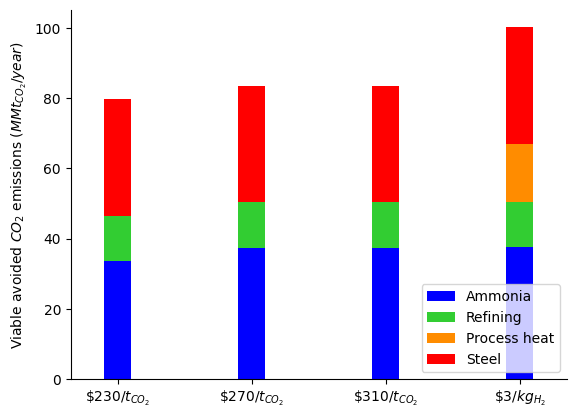

In [296]:
colors = ['blue', 'limegreen', 'darkorange',  'red'] ## Colors for the bars
viable_decarb_df.plot(kind='bar', stacked=True, color=colors, width=0.2) ## Plot
plt.ticklabel_format(style='plain', useOffset=False, axis='y') ## No offset
plt.gca().set_ylabel(r"Viable avoided $CO_2$ emissions ($MMt_{CO_2}/year$)") ## Set Y-axis
plt.gca().set_xticks(np.arange(viable_decarb_df.shape[0]), labels = gvt_incentives, rotation=0 )
plt.gca().spines[['right', 'top']].set_visible(False)
plt.gca().legend(loc='lower right')
plt.savefig('./results/viable_avoided_emissions_incentives.png')